# Load and Explore the Data

In [2]:
import pandas as pd

# Load the dataset
data = pd.read_csv("Historical Product Demand.csv")

# Display basic info
print(data.info())
print(data.head())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB
None
   Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500 
Product_Code            0
Warehouse               0
Product_Category        0
Date                11239


In [3]:
#Drop rows with missing date.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)
data.sort_values('Date')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011/1/8,2
131429,Product_0412,Whse_S,Category_007,2011/10/20,(2)
131426,Product_0125,Whse_S,Category_011,2011/10/20,(2)
75193,Product_0642,Whse_C,Category_019,2011/10/31,3
131026,Product_2137,Whse_S,Category_009,2011/11/18,(25)
...,...,...,...,...,...
919105,Product_0689,Whse_J,Category_011,2017/1/6,200
920147,Product_1970,Whse_J,Category_005,2017/1/6,2000
863020,Product_1904,Whse_C,Category_019,2017/1/9,4000
908844,Product_0471,Whse_C,Category_015,2017/1/9,30


In [4]:
#Get the lowest and highest dates in the dataset.
data['Date'].min() , data['Date'].max()
#There is data for 6 years. great.

('2011/1/8', '2017/1/9')

In [5]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Remove parentheses and convert to integer
data['Order_Demand'] = data['Order_Demand'].str.replace(r"[()]", "", regex=True).astype(int)


# Aggregate demand data monthly
data['Month'] = data['Date'].dt.to_period('M')
monthly_data = data.groupby(['Product_Code', 'Warehouse', 'Product_Category', 'Month'])['Order_Demand'].sum().reset_index()

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in ['Product_Code', 'Warehouse', 'Product_Category']:
    monthly_data[col] = encoder.fit_transform(monthly_data[col])

print(monthly_data.head())

   Product_Code  Warehouse  Product_Category    Month  Order_Demand
0             0          0                 4  2012-01          6400
1             0          0                 4  2012-02         10400
2             0          0                 4  2012-03         11000
3             0          0                 4  2012-04          1500
4             0          0                 4  2012-05          8000


In [6]:
# Create lag features
monthly_data['Lag_1'] = monthly_data.groupby(['Product_Code', 'Warehouse', 'Product_Category'])['Order_Demand'].shift(1)
monthly_data['Lag_2'] = monthly_data.groupby(['Product_Code', 'Warehouse', 'Product_Category'])['Order_Demand'].shift(2)

# Drop rows with NaN values caused by lag creation
monthly_data.dropna(inplace=True)

# Separate features and target
X = monthly_data[['Product_Code', 'Warehouse', 'Product_Category', 'Lag_1', 'Lag_2']]
y = monthly_data['Order_Demand']

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Feature engineering complete.")


Feature engineering complete.


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 6610738428.362781


In [8]:
import joblib

# Save the model
joblib.dump(model, "demand_forecasting_model.pkl")
print("Model saved as demand_forecasting_model.pkl.")


Model saved as demand_forecasting_model.pkl.


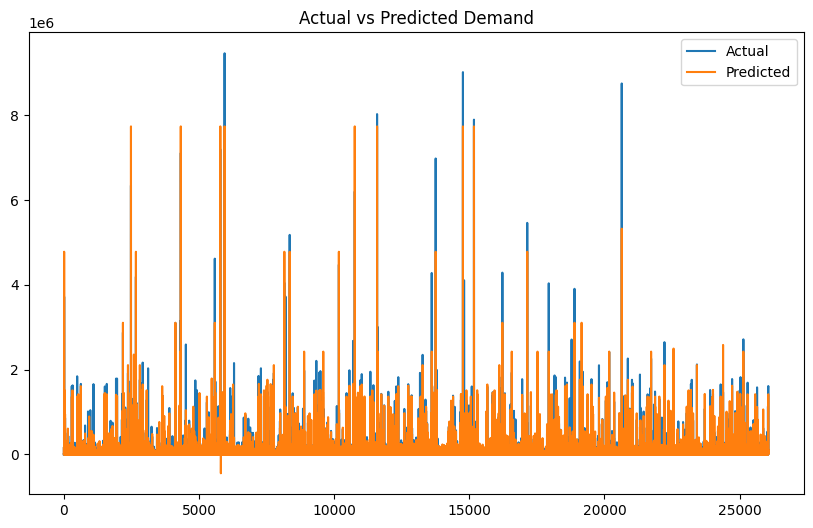

In [9]:
import matplotlib.pyplot as plt

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Demand")
plt.legend()
plt.show()


In [10]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [11]:

# Load the dataset
df = pd.read_csv("Historical Product Demand.csv")

In [12]:
#Don't judge it by the cover.
df.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [13]:
#Check the cardinality.
df.shape

(1048575, 5)

In [14]:
#Check the data types.
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [15]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

1  /  5
11239  /  1048575


In [16]:
#Drop na's.

#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;) 
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44795,Product_0965,Whse_A,Category_006,2011/11/18,1
44796,Product_0965,Whse_A,Category_006,2011/11/21,3
44797,Product_0965,Whse_A,Category_006,2011/11/21,5
44798,Product_0965,Whse_A,Category_006,2011/11/21,2
119561,Product_0980,Whse_A,Category_028,2011/11/21,100
107158,Product_0138,Whse_J,Category_007,2011/11/22,188
107159,Product_0138,Whse_J,Category_007,2011/11/22,1852
111727,Product_0982,Whse_A,Category_028,2011/11/22,3700
44102,Product_0980,Whse_A,Category_028,2011/11/23,1000
71915,Product_0980,Whse_A,Category_028,2011/11/23,200


In [17]:
#Target Feature - Order_Demand
#Removing () from the target feature.
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Next step is to change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [18]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

('2011/1/8', '2017/1/9')

In [19]:
#Lets start with 2012 and cap it 2016 december. Since the dates before 2012 have a lot of missing values - inspected and checked using basic time series plot.
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

C:\Users\Electrobot\AppData\Local\Temp\ipykernel_2020\2912268286.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df['Order_Demand'], fit=norm)


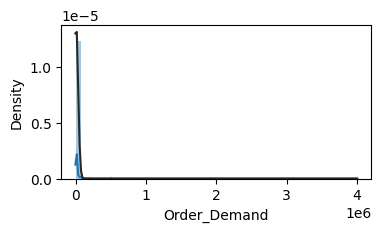

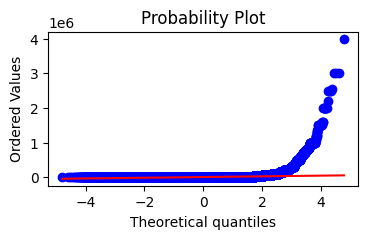

In [20]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sb.distplot(df['Order_Demand'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [21]:
#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
df['Order_Demand'].skew()

32.454972802177

In [22]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Warehouse
Whse_J    617987
Whse_A    116635
Whse_S     81403
Whse_C     31973
Name: count, dtype: int64

33


<Axes: xlabel='count', ylabel='Product_Category'>

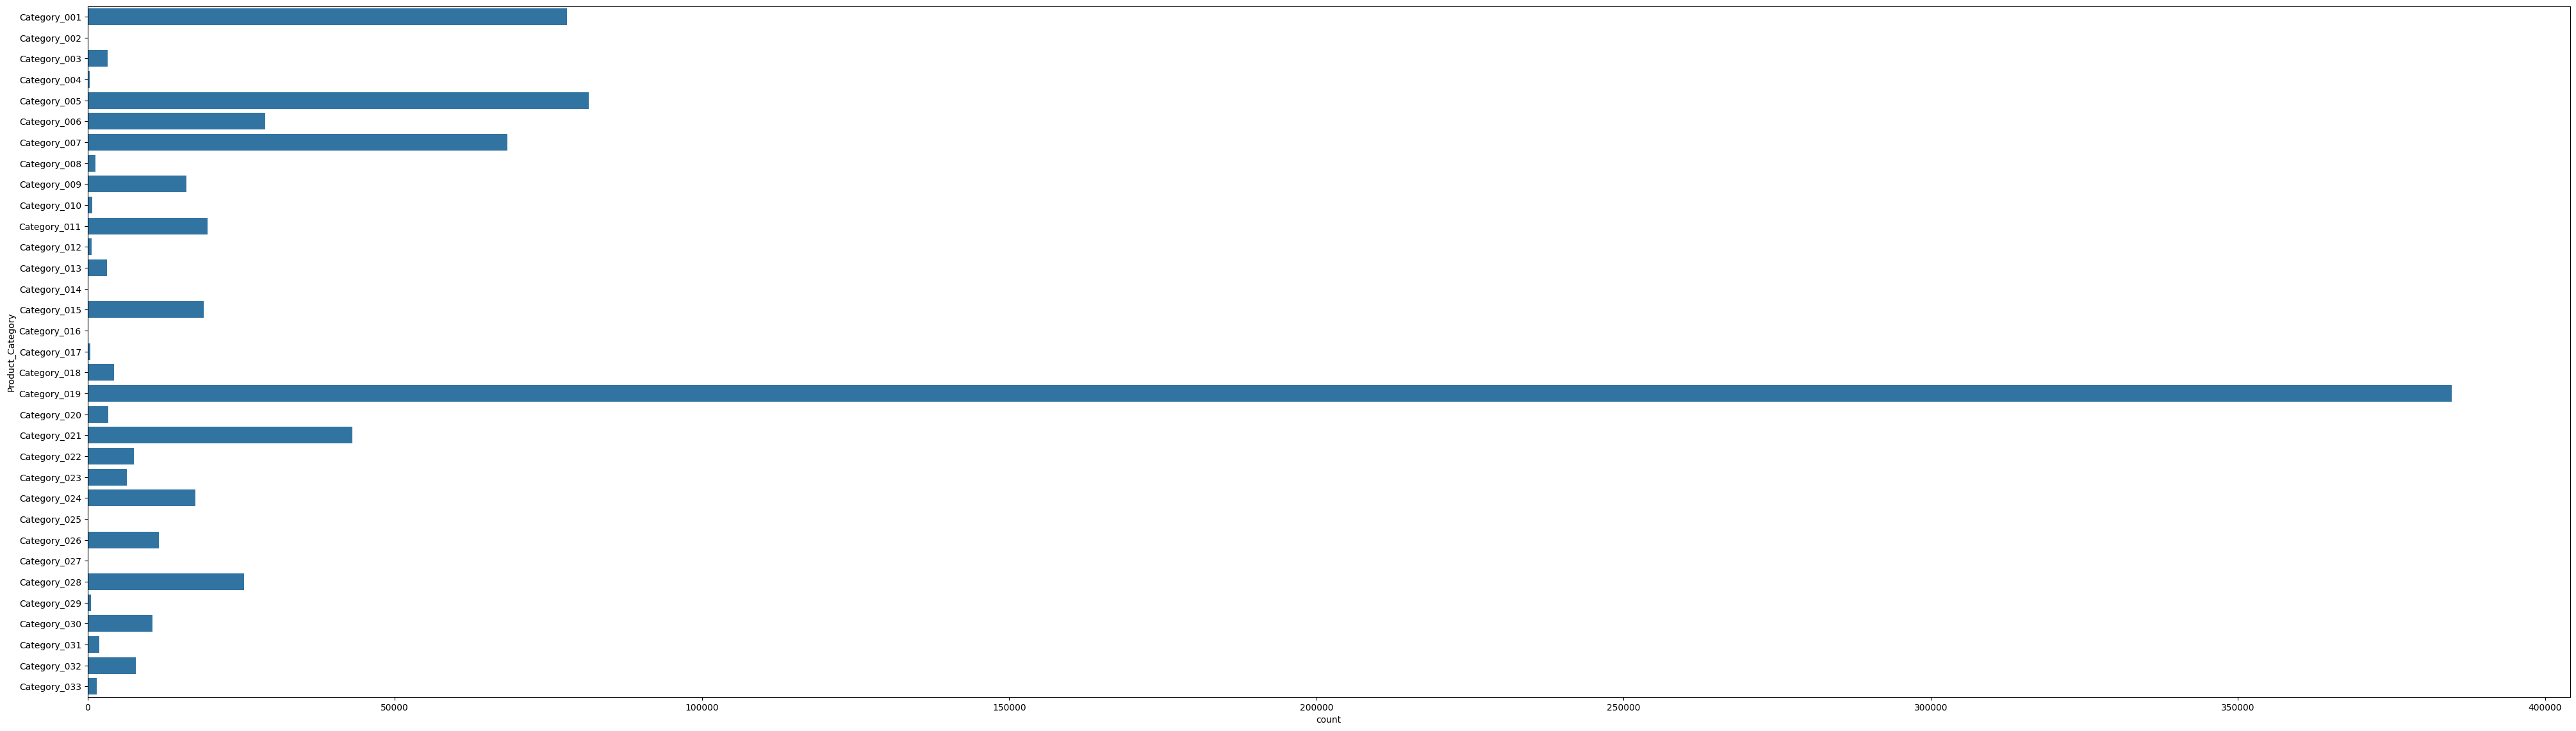

In [23]:
#Product Category.

print (len(df['Product_Category'].value_counts()))

rcParams['figure.figsize'] = 50,14
sb.countplot(df['Product_Category'].sort_values(ascending = True))

#There's a lot of orders on category19.

In [25]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
#This gives us the total orders placed on each day.

In [26]:
#Index the date
df = df.set_index('Date')
df.index #Lets check the index

Index(['2012/1/1', '2012/1/10', '2012/1/11', '2012/1/12', '2012/1/13',
       '2012/1/15', '2012/1/16', '2012/1/17', '2012/1/18', '2012/1/19',
       ...
       '2015/9/28', '2015/9/29', '2015/9/3', '2015/9/30', '2015/9/4',
       '2015/9/5', '2015/9/6', '2015/9/7', '2015/9/8', '2015/9/9'],
      dtype='object', name='Date', length=1360)

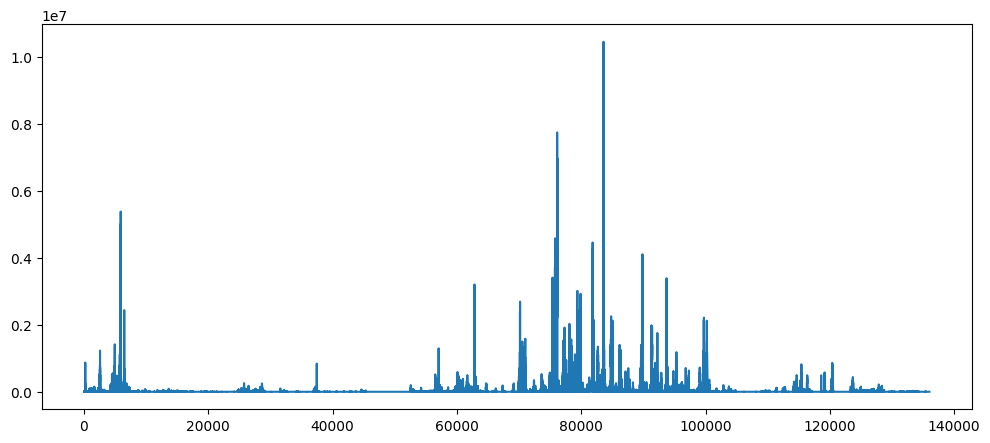

In [28]:


y.plot(figsize=(12,5))
plt.show()

#Takeaway: The sales are always low for the beginning of the year and the highest peak in demand every year is in the
#last quarter. The observed trend shows that orders were higher during 2014-2016 then reducing.

#Lets check it by decomposition.

In [30]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [31]:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:214689673966.24835


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3566522.673820684


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3567682.245110344


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3515751.512130236


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3502560.1625842797


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3502710.1201985804


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3515673.177038539


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3501578.763181909


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3550790.7626353884


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3534374.0406521074


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3481333.264554433


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3472271.357855216


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3525226.0382977454


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3524613.3230118384


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3473574.5775405825


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3462811.178177046


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3407321.327265722


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3395760.3778732726


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1.8226955255556574e+20


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:3402196.7099084677


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:3395788.3582749246


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:3395742.6503529623


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:3448069.8851951575


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:3401137.230922192


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:3361204.266154888


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3360898.8753373767


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:3450108.2197113927


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3386484.386243235


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:3360948.480169753


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3360900.8524972405


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:3418431.6284067617


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:3386481.692415416


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:3390323.983659717


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:3389443.340835033


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:3454838.05062795


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:3403284.981410024


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:3389417.9197377292


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:3389230.6041195244


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:3431605.1167901317


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:3402913.974053985


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:3360333.1786937406


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3360009.7273224206


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:3443637.676433188


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3381898.4766035485


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:3360034.2454212895


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:3360000.8675057953


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:3413773.941970959


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:3381885.940133115


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:3372375.94087273


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:3372072.411727952


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:3461371.063635118


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:3396439.065305631


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:3372072.513384824


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:3372074.6751851463


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:3429481.8726033075


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:3396437.862027581


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:3361115.110911007


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:3360803.975626382


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:3449447.184768626


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:3386295.0406565717


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:3360828.805839697


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3360806.0171351563


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:3418259.020827397


c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:3386289.509832507


In [34]:
#Fit the model with the best params.
#ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:3360000.8675057953


#The above output suggests that ARIMA(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value: 960.516
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Electrobot\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9851   4.24e-05   2.33e+04      0.000       0.985       0.985
ma.L1         -0.5581      0.000  -4022.849      0.000      -0.558      -0.558
ar.S.L12       0.6230      0.016     38.705      0.000       0.591       0.655
ma.S.L12      -0.6090      0.016    -37.365      0.000      -0.641      -0.577
sigma2      9.391e+09   3.21e-11   2.92e+20      0.000    9.39e+09    9.39e+09


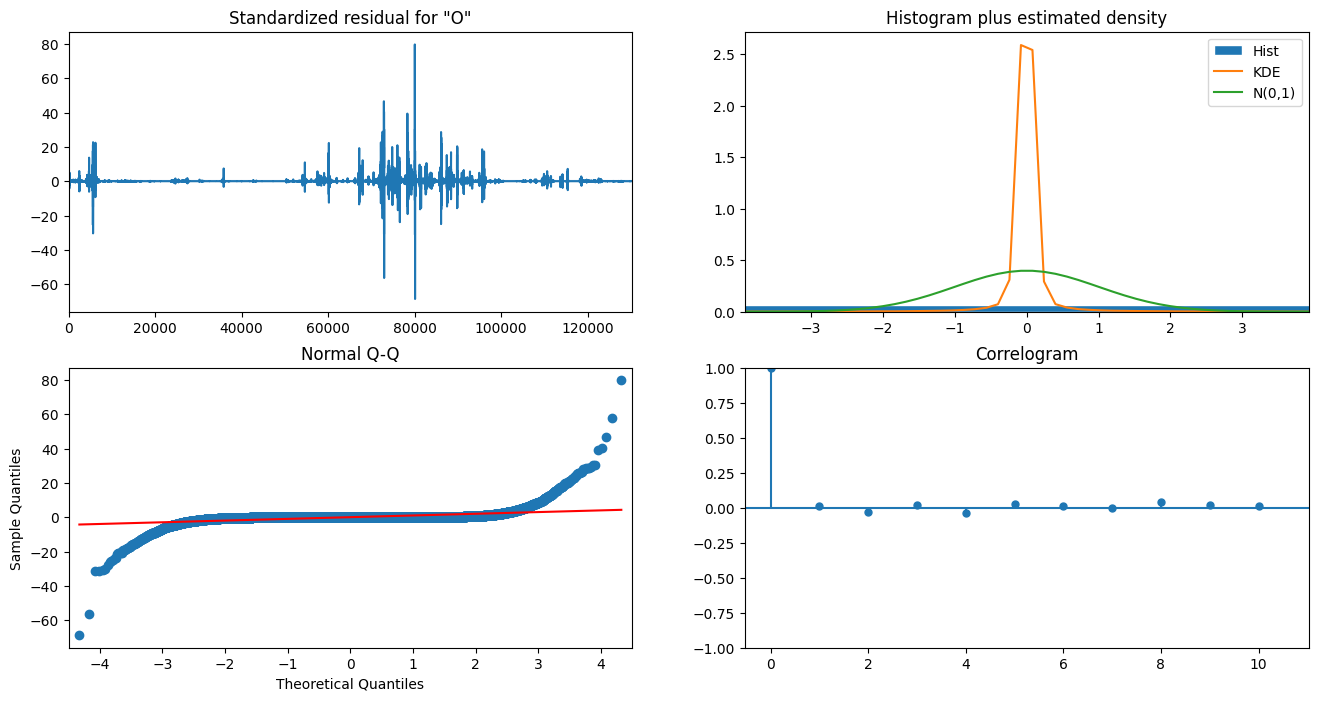

In [35]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.

In [ ]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

In [38]:
import joblib

# Save the model
joblib.dump(mod, "demand_forecasting_arima.pkl")
print("Model saved as demand_forecasting_model.pkl.")

Model saved as demand_forecasting_model.pkl.
